# Physics-Informed Neural Network (PINN) in Julia

This is a simple showcase of how PINNs can learn the solution to (Partial) Differential Equations without labelled data by leveraging automatic differentation to train on a residuum loss of the boundary value problem.

We will consider the 1D Poisson equation
$$
\begin{cases}
\frac{\partial^2 u}{\partial x^2} &= - f(x), \qquad & x \in \Omega = (0, 1)
\\
u(0) &= 0 = u(1)
\end{cases}
$$

For $f(x) = \sin(\pi x)$, the analytical solution is $\hat{u}(x) = \frac{1}{\pi^2} \sin(\pi x)$. We aim to train a shallow neural network to learn the mapping $x \mapsto u$.

This can be done by chosing collocation points, i.e., random points within the domain at which we enfore the PDE. A difference of the neural network against this underlying description will constitute to the loss. Additionally, we will also penalize if the network does not obey the homogeneous Dirichlet boundary conditions. As such our loss is

$$
\mathcal{L} = \alpha_{int} \frac{1}{2N} \sum_{i=1}^N \left( \frac{\partial^2 u}{\partial x^2}\bigg|_{x_i} + f(x_i)  \right)^2  + \alpha_{bc} \frac{1}{2 \cdot 2} \left( u(0)^2 + u(1)^2 \right)
$$

with hyperparameters to weigh the two components of the loss. Our neural network is parameterized by its weights and biases. We can backprop from this loss into the parameter space to obtain a gradient estimate which guides a gradient-based optimizer (here we will use ADAM).

**Julia's reverse-mode automatic differentiation ecosystem, as of now, does not properly support higher-order autodiff**. However, this is crucial, because ultimately we need three autodiff passes, two to get the second derivative within the loss formulation and another one to obtain a gradient estimate in the parameter space.

## Employed architecture

This intro follows the work of Lagaris et al. ([https://arxiv.org/abs/physics/9705023](https://arxiv.org/abs/physics/9705023)) that use a neural network with **one hidden layer**. By the universal approximation theorem, this is sufficient to capture (almost) any function. Hence, given the hidden layer is chosen large enough, it should also be possible to approximate the solution to the PDE. The forward pass of the network becomes

$$
u = v^T \sigma.(w x + b)
$$

We assume our network to be a scalar-to-scalar map, hence

$$
x \in \R, w \in \R^h, b \in \R^h, v \in \R^h, u \in \R
$$

with $h$ being the size of the hidden dimension.

### Analytical Input-Output derivative

**Our goal is to reduce to only one application of the Julia reverse-mode autodiff engine; the pullback from loss to parameter space.** As such, we want to find hand-coded derivatives for the network architecture in their input-output relation.

We can derive this simple shallow network to get

$$
\begin{aligned}
\frac{\partial u}{\partial x} &= (v \odot w)^T \sigma'(w x + b)
\\
\frac{\partial^2 u}{\partial x^2} &= (v \odot w.^2)^T \sigma''(w x + b)
\\
\frac{\partial^l u}{\partial x^l} &= (v \odot w.^l)^T \sigma^{(l)}(w x + b)
\end{aligned}
$$

### The batched case

For all practical applications, we want to query our network batched, i.e., for multiple inputs at the same time. Following the Julia convention, we will therefore the denote the collection of inputs as $x \in \R^{1 \times N}$ and the collection of outputs as $u \in \R^{1 \times N}$. As such, the forward pass becomes

$$
u = V \cdot \sigma.(W \cdot x .+ b)
$$

with the sizes

$$
x \in \R^{1 \times N}, W \in \R^{h, 1}, b \in \R^h, V \in \R^{1, h}, u \in \R^{1 \times N}
$$

### Properties of the sigmoid

Its higher derivatives can be expressed using the primal output

$$
\begin{aligned}
\sigma(x) &= \frac{1}{1 + e^{-x}}
\\
\sigma' &= \sigma (1 - \sigma)
\\
\sigma'' &= \sigma (1 - \sigma) \left( 1- 2\sigma \right) = \sigma' \left( 1- 2\sigma \right)
\end{aligned}
$$



In [2]:
using Optimisers, Zygote, Plots, Random, Distributions

In [3]:
SEED = 42
N_collocation_points = 50
HIDDEN_DEPTH = 100
LEARNING_RATE = 1e-3
N_EPOCHS = 20_000
BC_LOSS_WEIGHT = 100.0

100.0

In [4]:
rhs_function(x) = sin(π * x)
analytical_solution(x) = sin(π * x) / π^2

analytical_solution (generic function with 1 method)

In [5]:
rng = MersenneTwister(SEED)

MersenneTwister(42)

In [6]:
sigmoid(x) = 1.0 / (1.0 + exp(-x))

sigmoid (generic function with 1 method)

In [7]:
# Initialize the weights according to the Xavier Glorot initializer
uniform_limit = sqrt(6 / (1 + HIDDEN_DEPTH))
W = rand(
    rng,
    Uniform(-uniform_limit, +uniform_limit),
    HIDDEN_DEPTH,
    1,
)
V = rand(
    rng,
    Uniform(-uniform_limit, +uniform_limit),
    1,
    HIDDEN_DEPTH,
)
b = zeros(HIDDEN_DEPTH)

100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [8]:
parameters = (; W, V, b)

(W = [0.016175614604269584; -0.02240926457030354; … ; -0.149288583098366; 0.1288046124568631;;], V = [-0.1689182588519061 -0.23049647793464587 … 0.027150454140853042 0.23920576197816756], b = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [10]:
network_forward(x, p) = p.V * sigmoid.(p.W * x .+ p.b)

network_forward (generic function with 1 method)

In [13]:
x_line = reshape(collect(range(0.0, stop=1.0, length=100)), (1, 100))

1×100 Matrix{Float64}:
 0.0  0.010101  0.020202  0.030303  …  0.969697  0.979798  0.989899  1.0

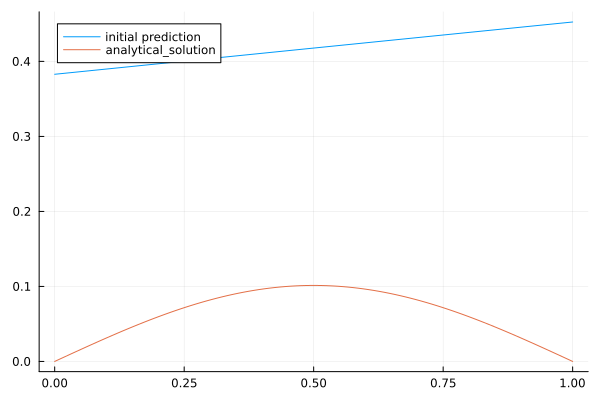

In [18]:
# Plot initial prediction of the network (together with the analytical solution)
plot(x_line[:], network_forward(x_line, parameters)[:], label="initial prediction")
plot!(x_line[:], analytical_solution.(x_line[:]), label="analytical_solution")

In [19]:
function network_output_and_first_two_derivatives(x, p)
    activated_state = sigmoid.(p.W * x .+ p.b)
    sigmoid_prime = activated_state .* (1.0 .- activated_state)
    sigmoid_double_prime = sigmoid_prime .* (1.0 .- 2.0 .* activated_state)

    output = p.V * activated_state
    first_derivative = (p.V .* p.W') * sigmoid_prime
    second_derivative = (p.V .* p.W' .* p.W') * sigmoid_double_prime

    return output, first_derivative, second_derivative
end

network_output_and_first_two_derivatives (generic function with 1 method)

In [21]:
_output, _first_derivative, _second_derivative = network_output_and_first_two_derivatives(x_line, parameters)

([0.38282994071528714 0.3835365359378942 … 0.4518323843431763 0.45253146349204787], [0.06995295282877508 0.06995287545697229 … 0.06921631175116728 0.06920133527345308], [0.0 -1.531960301644129e-5 … -0.0014754077309355313 -0.0014899322179842476])

In [26]:
_first_derivative

1×100 Matrix{Float64}:
 0.069953  0.0699529  0.0699526  …  0.0692311  0.0692163  0.0692013

In [28]:
_zygote_first_derivative = Zygote.gradient(x -> sum(network_forward(x, parameters)), x_line)[1]

1×100 Matrix{Float64}:
 0.069953  0.0699529  0.0699526  …  0.0692311  0.0692163  0.0692013

In [29]:
interior_collocation_points = rand(rng, Uniform(0.0, 1.0), (1, N_collocation_points))

1×50 Matrix{Float64}:
 0.0782252  0.814367  0.527343  0.439753  …  0.057363  0.165505  0.301515

In [30]:
boundary_collocation_points = [0.0 1.0]

1×2 Matrix{Float64}:
 0.0  1.0

In [31]:
function loss_forward(p)
    output, first_derivative, second_derivative = network_output_and_first_two_derivatives(
        interior_collocation_points,
        p,
    )

    interior_residuals = second_derivative .+ rhs_function.(interior_collocation_points)

    interior_loss = 0.5 * mean(interior_residuals.^2)

    boundary_residuals = network_forward(boundary_collocation_points, p) .- 0.0

    boundary_loss = 0.5 * mean(boundary_residuals.^2)

    total_loss = interior_loss + BC_LOSS_WEIGHT * boundary_loss

    return total_loss
end

loss_forward (generic function with 1 method)

In [32]:
loss_forward(parameters)

9.040270399948872

In [33]:
out, back = Zygote.pullback(loss_forward, parameters)

(9.040270399948872, Zygote.var"#75#76"{Zygote.Pullback{Tuple{typeof(loss_forward), NamedTuple{(:W, :V, :b), Tuple{Matrix{Float64}, Matrix{Float64}, Vector{Float64}}}}, Tuple{Zygote.var"#back#241"{Zygote.var"#2033#back#209"{Zygote.var"#back#207"{3, 1, Zygote.Context{false}, Matrix{Float64}}}}, Zygote.var"#3882#back#1235"{Zygote.var"#1231#1234"{2, Matrix{Float64}}}, Zygote.Pullback{Tuple{typeof(Base.Broadcast.materialize), Matrix{Float64}}, Tuple{}}, Zygote.var"#1990#back#190"{Zygote.var"#186#189"{Zygote.Context{false}, GlobalRef, Matrix{Float64}}}, Zygote.var"#3882#back#1235"{Zygote.var"#1231#1234"{2, Matrix{Float64}}}, Zygote.var"#1990#back#190"{Zygote.var"#186#189"{Zygote.Context{false}, GlobalRef, Matrix{Float64}}}, Zygote.var"#2033#back#209"{Zygote.var"#back#207"{2, 1, Zygote.Context{false}, Matrix{Float64}}}, Zygote.var"#1990#back#190"{Zygote.var"#186#189"{Zygote.Context{false}, GlobalRef, Float64}}, Zygote.var"#1926#back#157"{Zygote.var"#153#156"}, Zygote.Pullback{Tuple{typeof(Bas

In [35]:
back(1.0)[1]

(W = [-0.955443113070862; -1.3036603118309367; … ; 0.1526634807164687; 1.3470820959933296;;], V = [20.975532641257928 20.757279594338037 … 20.04124599827881 21.61155520116418], b = [-1.7637813964526188, -2.406675355296456, -1.2359608992290003, 0.2796218338153964, 0.7451103564195863, 1.6837261780741946, -2.142379882819124, -1.307929356859464, -1.4777507599377748, -2.286056294300193  …  -0.046797536106913735, 0.19934632661406246, 2.2793652594093827, 1.62942061248934, 1.716968130763224, -0.8188414326330922, 0.8492395778005775, -1.4035430065878878, 0.2826049286449616, 2.4918785213941685])

In [36]:
opt = Adam(LEARNING_RATE)

Adam{Float64}(0.001, (0.8999999761581421, 0.9990000128746033), 2.220446049250313e-16)

In [37]:
opt_state = Optimisers.setup(opt, parameters)
loss_history = []
for i in 1:N_EPOCHS
    loss, back = Zygote.pullback(loss_forward, parameters)
    push!(loss_history, loss)
    grad, = back(1.0)
    opt_state, parameters = Optimisers.update(opt_state, parameters, grad)
    if i % 100 == 0
        println("Epoch: $i, Loss: $loss")
    end
end

Epoch: 100, Loss: 0.25990676481808384
Epoch: 200, Loss: 0.2573436244866155
Epoch: 300, Loss: 0.2573244029115608
Epoch: 400, Loss: 0.25731151997859136
Epoch: 500, Loss: 0.25729658968561137
Epoch: 600, Loss: 0.2572797206629173
Epoch: 700, Loss: 0.2572609747328376
Epoch: 800, Loss: 0.2572403810566642
Epoch: 900, Loss: 0.25721794280158394
Epoch: 1000, Loss: 0.25719363989568067
Epoch: 1100, Loss: 0.2571674294599614
Epoch: 1200, Loss: 0.25713924460099413
Epoch: 1300, Loss: 0.2571089918317986
Epoch: 1400, Loss: 0.25707654715959927
Epoch: 1500, Loss: 0.2570417507218213
Epoch: 1600, Loss: 0.25700439971391537
Epoch: 1700, Loss: 0.256964239203819
Epoch: 1800, Loss: 0.2569209502436297
Epoch: 1900, Loss: 0.25687413444251567
Epoch: 2000, Loss: 0.2568232938202603
Epoch: 2100, Loss: 0.2567678042655694
Epoch: 2200, Loss: 0.25670688019643434
Epoch: 2300, Loss: 0.256639526932927
Epoch: 2400, Loss: 0.25656447563685336
Epoch: 2500, Loss: 0.25648009310008313
Epoch: 2600, Loss: 0.25638425458168895
Epoch: 270

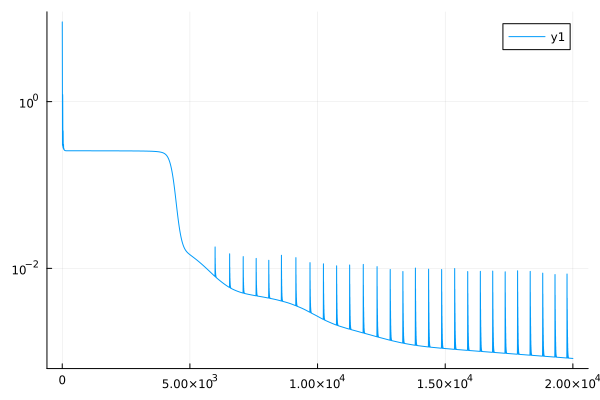

In [38]:
plot(loss_history, yscale=:log10)

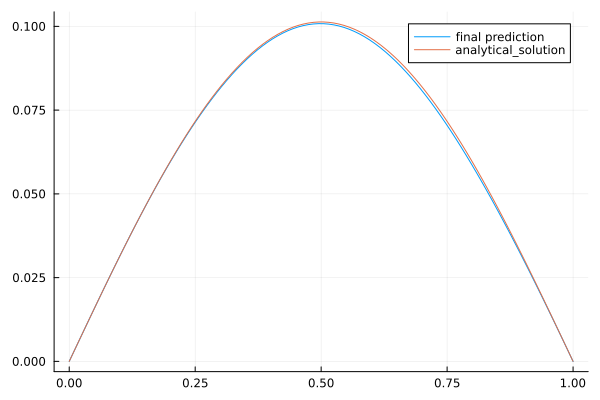

In [39]:
plot(x_line[:], network_forward(x_line, parameters)[:], label="final prediction")
plot!(x_line[:], analytical_solution.(x_line[:]), label="analytical_solution")